## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type, 1) or '1type' as

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5,0.7]
redice_lr_patient = [5,10,25]

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
b

50000/50000 [==============================] - 6s 126us/step - loss: 1.4866 - accuracy: 0.4818 - val_loss: 1.5898 - val_accuracy: 0.4421
Epoch 9/25
50000/50000 [==============================] - 6s 125us/step - loss: 1.4591 - accuracy: 0.4933 - val_loss: 1.5725 - val_accuracy: 0.4458
Epoch 10/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.4336 - accuracy: 0.5015 - val_loss: 1.5600 - val_accuracy: 0.4511
Epoch 11/25
50000/50000 [==============================] - 6s 124us/step - loss: 1.4106 - accuracy: 0.5082 - val_loss: 1.5473 - val_accuracy: 0.4557
Epoch 12/25
50000/50000 [==============================] - 6s 121us/step - loss: 1.3885 - accuracy: 0.5175 - val_loss: 1.5359 - val_accuracy: 0.4581
Epoch 13/25
50000/50000 [==============================] - 6s 125us/step - loss: 1.3679 - accuracy: 0.5254 - val_loss: 1.5287 - val_accuracy: 0.4625
Epoch 14/25
50000/50000 [==============================] - 6s 112us/step - loss: 1.3488 - accuracy: 0.5311 - val_loss: 

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 126us/step - loss: 2.3138 - accuracy: 0.2342 - val_loss: 2.1480 - val_accuracy: 0.1694
Epoch 2/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.8566 - accuracy: 0.3562 - val_loss: 2.0119 - val_accuracy: 0.2614
Epoch 3/25
50000/50000 [==============================] - 6s 127us/step - loss: 1.7280 - accuracy: 0.3981 - val_loss: 1.8925 - val_accuracy: 0.3164
Epoch 4/25
50000/50000 [==============================] - 6s 123us/step - loss: 1.6553 - accuracy: 0.4225 - val_loss: 1.7896 - val_accuracy: 0.3667
Epoch 5/25
50000/50000 [==============================] - 6s 113us/step - loss: 1.6021 - accuracy: 0.4401 - val_loss: 1.7162 - val_accuracy: 0.4022
Epoch 6/25
50000/50000 [==============================] - 6s 115us/step - loss: 1.5589 - accuracy: 0.4549 - val_loss: 1.6585 - val_accuracy: 0.4188
Epoch 7/25
50000/50000 [==============================] - 6s 1

50000/50000 [==============================] - 6s 118us/step - loss: 1.2360 - accuracy: 0.5736 - val_loss: 1.5129 - val_accuracy: 0.4675
Epoch 21/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.2200 - accuracy: 0.5800 - val_loss: 1.5085 - val_accuracy: 0.4656
Epoch 22/25
50000/50000 [==============================] - 6s 115us/step - loss: 1.2059 - accuracy: 0.5859 - val_loss: 1.5021 - val_accuracy: 0.4741
Epoch 23/25
50000/50000 [==============================] - 6s 121us/step - loss: 1.1898 - accuracy: 0.5915 - val_loss: 1.4976 - val_accuracy: 0.4759
Epoch 24/25
50000/50000 [==============================] - 6s 114us/step - loss: 1.1758 - accuracy: 0.5966 - val_loss: 1.4987 - val_accuracy: 0.4734
Epoch 25/25
50000/50000 [==============================] - 6s 111us/step - loss: 1.1614 - accuracy: 0.6023 - val_loss: 1.4904 - val_accuracy: 0.4763
Numbers of exp: 5, reduce_factor: 0.70, reduce_patient: 25
Model: "model_6"
__________________________________________

Epoch 5/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.2492 - accuracy: 0.5615 - val_loss: 1.7676 - val_accuracy: 0.3902
Epoch 6/25
50000/50000 [==============================] - 7s 139us/step - loss: 1.1906 - accuracy: 0.5807 - val_loss: 1.8990 - val_accuracy: 0.3578
Epoch 7/25
50000/50000 [==============================] - 7s 131us/step - loss: 1.1445 - accuracy: 0.5967 - val_loss: 2.0229 - val_accuracy: 0.3487
Epoch 8/25
50000/50000 [==============================] - 6s 127us/step - loss: 1.0903 - accuracy: 0.6154 - val_loss: 1.8600 - val_accuracy: 0.3785
Epoch 9/25
50000/50000 [==============================] - 7s 134us/step - loss: 1.0474 - accuracy: 0.6323 - val_loss: 1.7950 - val_accuracy: 0.4084

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 10/25
50000/50000 [==============================] - 6s 130us/step - loss: 0.9485 - accuracy: 0.6718 - val_loss: 1.4992 - val_accuracy: 0.4848
Epoch 11/25
50000/50000 [=====

50000/50000 [==============================] - 7s 141us/step - loss: 0.6467 - accuracy: 0.7986 - val_loss: 1.5512 - val_accuracy: 0.4915
Epoch 24/25
50000/50000 [==============================] - 6s 124us/step - loss: 0.6248 - accuracy: 0.8051 - val_loss: 1.5515 - val_accuracy: 0.4926
Epoch 25/25
50000/50000 [==============================] - 6s 130us/step - loss: 0.6026 - accuracy: 0.8145 - val_loss: 1.5769 - val_accuracy: 0.4834
Numbers of exp: 8, reduce_factor: 0.50, reduce_patient: 25
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_25 (Batc (None, 512)               2048      
___________________________

Epoch 8/25
50000/50000 [==============================] - 6s 127us/step - loss: 1.1049 - accuracy: 0.6202 - val_loss: 1.4711 - val_accuracy: 0.4799
Epoch 9/25
50000/50000 [==============================] - 6s 124us/step - loss: 1.0697 - accuracy: 0.6338 - val_loss: 1.4894 - val_accuracy: 0.4665
Epoch 10/25
50000/50000 [==============================] - 7s 134us/step - loss: 1.0325 - accuracy: 0.6462 - val_loss: 1.4380 - val_accuracy: 0.4872
Epoch 11/25
50000/50000 [==============================] - 6s 125us/step - loss: 0.9960 - accuracy: 0.6606 - val_loss: 1.4791 - val_accuracy: 0.4816
Epoch 12/25
50000/50000 [==============================] - 6s 128us/step - loss: 0.9585 - accuracy: 0.6753 - val_loss: 1.4936 - val_accuracy: 0.4754
Epoch 13/25
50000/50000 [==============================] - 7s 138us/step - loss: 0.9262 - accuracy: 0.6888 - val_loss: 1.4718 - val_accuracy: 0.4845
Epoch 14/25
50000/50000 [==============================] - 7s 142us/step - loss: 0.8964 - accuracy: 0.6983 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 8s 157us/step - loss: 1.8405 - accuracy: 0.3702 - val_loss: 2.0115 - val_accuracy: 0.2735
Epoch 2/25
50000/50000 [==============================] - 7s 131us/step - loss: 1.5246 - accuracy: 0.4679 - val_loss: 1.8148 - val_accuracy: 0.3744
Epoch 3/25
50000/50000 [==============================] - 6s 129us/step - loss: 1.4284 - accuracy: 0.5045 - val_loss: 1.6502 - val_accuracy: 0.4338
Epoch 4/25
50000/50000 [==============================] - 7s 141us/step - loss: 1.3652 - accuracy: 0.5272 - val_loss: 1.6198 - val_accuracy: 0.4271
Epoch 5/25
50000/50000 [==============================] - 6s 129us/step - loss: 1.3111 - accuracy: 0.5474 - val_loss: 1.5819 - val_accuracy: 0.4336
Epoch 6/25
50000/50000 [==============================] - 7s 135us/step - loss: 1.2658 - accuracy: 0.5636 - val_loss: 1.4972 - val_accuracy: 0.4720
Epoch 7/25
50000/50000 [==============================] - 7s 1

Epoch 20/25
50000/50000 [==============================] - 6s 123us/step - loss: 0.6839 - accuracy: 0.7686 - val_loss: 1.6346 - val_accuracy: 0.4726
Epoch 21/25
50000/50000 [==============================] - 6s 130us/step - loss: 0.6624 - accuracy: 0.7758 - val_loss: 1.4984 - val_accuracy: 0.5103
Epoch 22/25
50000/50000 [==============================] - 6s 130us/step - loss: 0.6380 - accuracy: 0.7844 - val_loss: 1.6851 - val_accuracy: 0.4712

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 23/25
50000/50000 [==============================] - 6s 118us/step - loss: 0.5625 - accuracy: 0.8185 - val_loss: 1.4834 - val_accuracy: 0.5245
Epoch 24/25
50000/50000 [==============================] - 6s 127us/step - loss: 0.5413 - accuracy: 0.8266 - val_loss: 1.5708 - val_accuracy: 0.5155
Epoch 25/25
50000/50000 [==============================] - 7s 146us/step - loss: 0.5244 - accuracy: 0.8361 - val_loss: 1.5059 - val_accuracy: 0.5293
Numbers of exp: 13, reduc

50000/50000 [==============================] - 10s 195us/step - loss: 1.4884 - accuracy: 0.4810 - val_loss: 1.7525 - val_accuracy: 0.3865
Epoch 4/25
50000/50000 [==============================] - 11s 221us/step - loss: 1.4168 - accuracy: 0.5065 - val_loss: 1.6663 - val_accuracy: 0.4129
Epoch 5/25
50000/50000 [==============================] - 6s 122us/step - loss: 1.3575 - accuracy: 0.5275 - val_loss: 1.6283 - val_accuracy: 0.4243
Epoch 6/25
50000/50000 [==============================] - 7s 139us/step - loss: 1.3088 - accuracy: 0.5443 - val_loss: 1.6203 - val_accuracy: 0.4257
Epoch 7/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.2580 - accuracy: 0.5649 - val_loss: 1.6169 - val_accuracy: 0.4326
Epoch 8/25
50000/50000 [==============================] - 7s 141us/step - loss: 1.2146 - accuracy: 0.5783 - val_loss: 1.5415 - val_accuracy: 0.4590
Epoch 9/25
50000/50000 [==============================] - 7s 130us/step - loss: 1.1773 - accuracy: 0.5943 - val_loss: 1.6

50000/50000 [==============================] - 6s 117us/step - loss: 0.7629 - accuracy: 0.7525 - val_loss: 1.5132 - val_accuracy: 0.4937
Epoch 23/25
50000/50000 [==============================] - 6s 120us/step - loss: 0.7391 - accuracy: 0.7630 - val_loss: 1.6238 - val_accuracy: 0.4735
Epoch 24/25
50000/50000 [==============================] - 6s 118us/step - loss: 0.7190 - accuracy: 0.7708 - val_loss: 1.5341 - val_accuracy: 0.4878
Epoch 25/25
50000/50000 [==============================] - 6s 117us/step - loss: 0.6979 - accuracy: 0.7782 - val_loss: 1.6564 - val_accuracy: 0.4696
Numbers of exp: 16, reduce_factor: 0.70, reduce_patient: 10
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
________

50000/50000 [==============================] - 7s 134us/step - loss: 1.3953 - accuracy: 0.5175 - val_loss: 1.5988 - val_accuracy: 0.4420
Epoch 7/25
50000/50000 [==============================] - 6s 127us/step - loss: 1.3486 - accuracy: 0.5332 - val_loss: 1.5908 - val_accuracy: 0.4456
Epoch 8/25
50000/50000 [==============================] - 7s 140us/step - loss: 1.3071 - accuracy: 0.5502 - val_loss: 1.5810 - val_accuracy: 0.4456
Epoch 9/25
50000/50000 [==============================] - 7s 142us/step - loss: 1.2709 - accuracy: 0.5629 - val_loss: 1.5044 - val_accuracy: 0.4776
Epoch 10/25
50000/50000 [==============================] - 6s 128us/step - loss: 1.2339 - accuracy: 0.5779 - val_loss: 1.5253 - val_accuracy: 0.4718
Epoch 11/25
50000/50000 [==============================] - 6s 122us/step - loss: 1.2014 - accuracy: 0.5888 - val_loss: 1.4985 - val_accuracy: 0.4776
Epoch 12/25
50000/50000 [==============================] - 6s 124us/step - loss: 1.1704 - accuracy: 0.6026 - val_loss: 1.

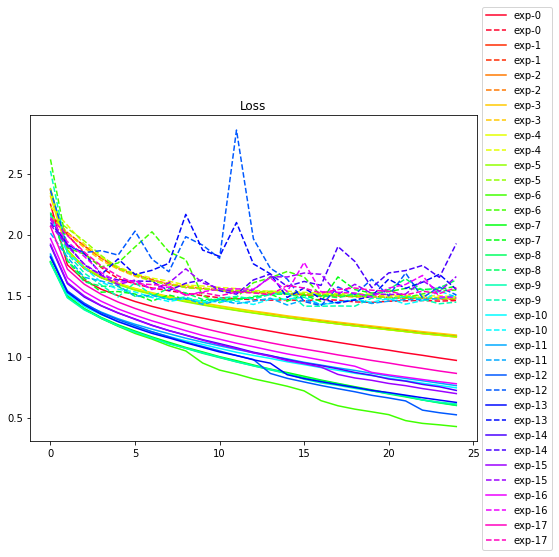

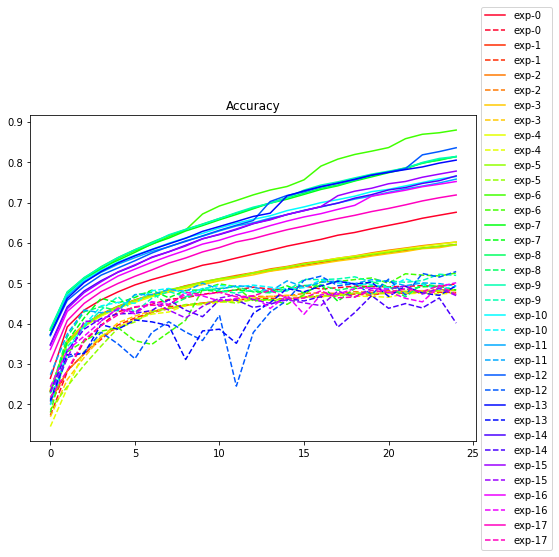

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()